In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!pip install tqdm -q
from tqdm import tqdm
tqdm.pandas()

DATA LOADING

In [2]:
dataset=pd.read_csv('processed_data.csv')

In [3]:
dataset.head()

,label,subject,email_to,email_from,message
0,1,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,0,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,1,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,1,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


In [4]:
# 0-ham
# 1-spam

DATA CLEANING

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       75419 non-null  int64 
 1   subject     74626 non-null  object
 2   email_to    74843 non-null  object
 3   email_from  75419 non-null  object
 4   message     73932 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


In [6]:
dataset.shape

(75419, 5)

In [7]:
dataset['label'].value_counts()# unbalanced data

label
1    50199
0    25220
Name: count, dtype: int64

In [8]:
dataset = dataset.drop_duplicates(subset=['message'], keep='first')
dataset['label'].value_counts()

label
1    34557
0    24491
Name: count, dtype: int64

In [9]:
dataset.drop(columns=['subject','email_to','email_from'],inplace=True)
df=dataset.copy()
df.rename(columns={'label':'target','message':'text'},inplace=True)
df.dropna(subset=['text'],inplace=True)
df.shape
df.index = range(len(df))

In [10]:
# dropping garbage words(if len(words)>30)

def reduce_words(L):
    L_new=[word for word in L if len(str(word)) <= 30]
    return ' '.join(L_new)

df['text']=df['text'].str.split(' ').apply(reduce_words)

In [11]:
# dropping html and urls

import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    text =re.sub(r'https?://\S+|www\.\S+', '', text) 
    return text

df['text']=df['text'].apply(clean_text)  

In [12]:
# dropping content-type,content transfer and similar words

def reduce_words3(L):
    L2=[]
    for word in L:
        if 'content' in str(word).lower() or 'bit' in str(word).lower() or 'text' in str(word).lower():
            continue
        else:
            L2.append(word)
    return ' '.join(L2)

df['text']=df['text'].str.split(' ').apply(reduce_words3)   

In [13]:
# removing \n,\t(tabs),\r(carriage return) 's
df['text']=df['text'].str.replace(r'[\n\t\r]', '', regex=True)

# combining multiple spaces to form a single space
df['text']=df['text'].str.replace(r'\s+', ' ', regex=True)

In [14]:
# spelling correction

!pip install symspellpy -q

import os
import urllib.request
from symspellpy import SymSpell, Verbosity

dictionary_path = "frequency_dictionary_en_82_765.txt"
if not os.path.exists(dictionary_path):
    url = "https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt"
    urllib.request.urlretrieve(url, dictionary_path)

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_sentence(text):
    corrected_words = []
    for word in str(text).split():  
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)  
        else:
            corrected_words.append(word)  
    return " ".join(corrected_words)

df['text']=df['text'].progress_apply(correct_sentence)

100%|████████████████████████████████████████████████████████████████████████████| 59047/59047 [17:05<00:00, 57.58it/s]


In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# final cleaning, but not dropping punctation
# converting to lower case
# removing anything inside bracket with spaces
# Removing spaces only between single characters/numbers
# Merging multiple spaces into a single one

def reduce_words4(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', ' ', text)    
    text = re.sub(r'\[[^]]*\]', ' ', text)   
    text = re.sub(r'\{[^}]*\}', ' ', text)   
    text = re.sub(r'(?<=\b\w)\s(?=\w\b)', '', text) 
    text = " ".join(text.split())
    return text

    
df['text']=df["text"].apply(reduce_words4)

In [17]:
# dropping all empty strings

indices_to_drop=df[df['text'].apply(len)==0].index
df.drop(indices_to_drop, inplace=True)
df.index = range(len(df))

df.head()

,target,text
0,1,to you feel the pressure to perform and not ri...
1,0,in i've just updated from the gurus and a chec...
2,1,authentic aaaaaa discount price aaaaa $discoun...
3,1,key billy it was really fun going out the othe...
4,1,"multipart/alternative; quoted-printablesystem""..."


In [18]:
# num of characters,words and sentences column

import nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize, sent_tokenize

def wrd_tkenize(text):
    return word_tokenize(str(text))

df['num_characters'] = df['text'].progress_apply(len)
df['num_sentences'] = df['text'].progress_apply(lambda x: len(sent_tokenize(str(x))))

df['words_in_text'] = df['text'].progress_apply(wrd_tkenize)
df['num_words']=df['words_in_text'].progress_apply(len)

df.head()

100%|████████████████████████████████████████████████████████████████████████| 58768/58768 [00:00<00:00, 469968.31it/s]


,target,text,num_characters,num_sentences,words_in_text,num_words
0,1,to you feel the pressure to perform and not ri...,163,1,"[to, you, feel, the, pressure, to, perform, an...",36
1,0,in i've just updated from the gurus and a chec...,497,4,"[in, i, 've, just, updated, from, the, gurus, ...",84
2,1,authentic aaaaaa discount price aaaaa $discoun...,177,1,"[authentic, aaaaaa, discount, price, aaaaa, $,...",31
3,1,key billy it was really fun going out the othe...,601,1,"[key, billy, it, was, really, fun, going, out,...",123
4,1,"multipart/alternative; quoted-printablesystem""...",4971,9,"[multipart/alternative, ;, quoted-printablesys...",869


In [19]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,58768.000000,58768.000000,58768.000000
mean,1597.840083,289.695906,2.800010
std,2964.527833,520.215944,3.775892
min,1.000000,1.000000,1.000000
25%,451.000000,86.000000,1.000000
50%,904.000000,162.000000,2.000000
75%,1699.250000,305.000000,3.000000
max,316927.000000,52604.000000,145.000000


In [20]:
# transforming the text
# convert to lower case- already there
# tokenization
# remove special characters
# remove stop words and punctuations()
# stemming

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

nltk.download('stopwords',quiet=True)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def transform_text(L):
    tokens = [t for t in L if t.isalnum()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [ps.stem(t) for t in tokens]
    return " ".join(tokens)

df['transformed_text'] = df['words_in_text'].progress_apply(transform_text)    

100%|███████████████████████████████████████████████████████████████████████████| 58768/58768 [05:15<00:00, 186.35it/s]


In [21]:
df.head(3)

,target,text,num_characters,num_sentences,words_in_text,num_words,transformed_text
0,1,to you feel the pressure to perform and not ri...,163,1,"[to, you, feel, the, pressure, to, perform, an...",36,feel pressur perform rise occas tri aa anxieti...
1,0,in i've just updated from the gurus and a chec...,497,4,"[in, i, 've, just, updated, from, the, gurus, ...",84,updat guru check seem littl typo lenni access ...
2,1,authentic aaaaaa discount price aaaaa $discoun...,177,1,"[authentic, aaaaaa, discount, price, aaaaa, $,...",31,authent aaaaaa discount price aaaaa discount p...


In [22]:
# again dropping the rows which are empty after transformation

L3=df[df['transformed_text'] == ""].index
df.drop(L3,inplace=True)

df['target'].value_counts()# fairly balanced dataset

target
1    33158
0    24483
Name: count, dtype: int64

total words in spam 4521057
total words in ham 3797029


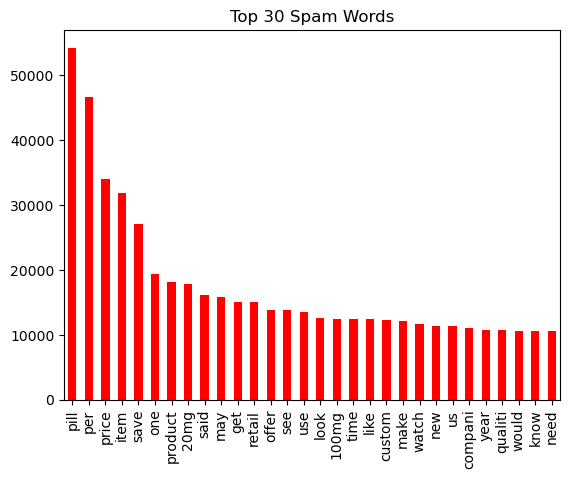

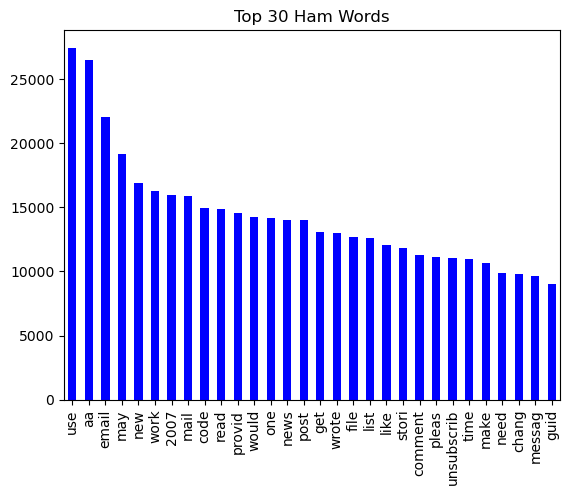

In [23]:
# most common words in spam and ham

spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
print('total words in spam',len(spam_corpus))

ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

print('total words in ham',len(ham_corpus))        

plt.figure()
spam_words = pd.Series(spam_corpus)
spam_words.value_counts().head(30).plot(kind='bar', color='red')
plt.title("Top 30 Spam Words")
plt.show()

# Ham words figure
plt.figure()
ham_words = pd.Series(ham_corpus)
ham_words.value_counts().head(30).plot(kind='bar', color='blue')
plt.title("Top 30 Ham Words")
plt.show()

In [24]:
# export dataset

In [25]:
#file_name='emails_cleaned'
#df.to_csv(file_name + ".csv", index=False)

In [26]:
#df=pd.read_csv('emails_cleaned.csv')

In [27]:
df.shape

(57641, 7)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57641 entries, 0 to 58767
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   target            57641 non-null  int64 
 1   text              57641 non-null  object
 2   num_characters    57641 non-null  int64 
 3   num_sentences     57641 non-null  int64 
 4   words_in_text     57641 non-null  object
 5   num_words         57641 non-null  int64 
 6   transformed_text  57641 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB


MODEL SELECTION 

In [29]:
# using naive bayes

In [30]:
# firstly we would use count vectorizer and next we would be using tfidf

In [31]:
# using count vectorizer

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Keep ALL features
cv = CountVectorizer()  
x = cv.fit_transform(df['transformed_text'])   # sparse matrix 

y = df['target'].values

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=2
)

print(x_train.shape, x_test.shape)
print(type(x_train))

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

mnb = MultinomialNB()
bnb = BernoulliNB()

(46112, 247141) (11529, 247141)
<class 'scipy.sparse._csr.csr_matrix'>


In [33]:
mnb.fit(x_train,y_train)
y_pred2 = mnb.predict(x_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9541157082140689
[[4850   37]
 [ 492 6150]]
0.9940197187651527


In [34]:
bnb.fit(x_train,y_train)
y_pred3 = bnb.predict(x_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.949084916298031
[[4633  254]
 [ 333 6309]]
0.9612981868048148


In [35]:
# although gave good results, lets try using tfidf too

In [36]:
# tfidf

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Useing TF-IDF 
tfidf = TfidfVectorizer()

x = tfidf.fit_transform(df['transformed_text'])  
y = df['target'].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=2)

mnb = MultinomialNB()
bnb = BernoulliNB()

In [38]:
mnb.fit(x_train,y_train)
y_pred2 = mnb.predict(x_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9682539682539683
[[4708  179]
 [ 187 6455]]
0.9730177871570697


In [39]:
bnb.fit(x_train,y_train)
y_pred3 = bnb.predict(x_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.949084916298031
[[4633  254]
 [ 333 6309]]
0.9612981868048148


In [40]:
#logistic regresssion
#Initially we would use gcv to find best parameters and than use those in the logistic regression and will also apply 
# the cross validation to get a mean precision value

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['transformed_text'])
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

logreg = LogisticRegression(solver='liblinear', max_iter=1000)

#hyperparameter grid (regularization and parameter)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100,1000],      
    'penalty': ['l1', 'l2']}

#Initializing GridSearchCV
grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='precision',   
    cv=5,                 
    n_jobs=-1,            
    verbose=2)

#Fitting the grid search
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV precision:", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1000, 'penalty': 'l1'}
Best CV precision: 0.9860758146701512


In [42]:
from sklearn.model_selection import cross_val_score

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['transformed_text'])
y = df['target'].values

logreg = LogisticRegression(
    solver='liblinear',
    C=grid.best_params_['C'],
    penalty=grid.best_params_['penalty'],
    max_iter=1000)

# Applying KFold cross-validation
precision_scores = cross_val_score(logreg, X, y, cv=5, scoring='precision')

print("Precision scores for each fold:", precision_scores)
print("Mean precision:", precision_scores.mean())

Precision scores for each fold: [0.98392965 0.98470012 0.97838811 0.98479831 0.98065967]
Mean precision: 0.9824951749261632


In [43]:
# 8. Evaluating on test set
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)


print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Test Accuracy: 0.9825657038771793
Confusion Matrix:
 [[4766  121]
 [  80 6562]]
Precision: 0.9818943588208888
Recall: 0.9879554351099067
F1 Score: 0.9849155722326454


In [44]:
#  Using Recurrent Neural Network

In [45]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Parameters(training the whole data is time cosuming and the accuracy,precision isnt too high)

max_vocab = 30000     # keeping only top 30k words
max_len = 400         # max sequence length (padding)
embedding_dim = 200   # embedding size

# Tokenize text
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(df['transformed_text'])
sequences = tokenizer.texts_to_sequences(df['transformed_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len)
y = df['target'].values  # 0 = ham, 1 = spam

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
#Simple RNN model
model = Sequential(name="email_classifier")
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim))
model.add(SimpleRNN(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  

model.summary()

Model: "email_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 400, 200)            │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 128)                 │          42,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,042,241 (23.05 MB)

 Trainable params: 6,042,241 (23.05 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','precision'])
callback=EarlyStopping(monitor='val_loss',
                       min_delta=0.0001,
                       patience=2,
                       mode='auto',
                       baseline=None,
                       restore_best_weights=True,
                       verbose=1)

# Train
history = model.fit(X_train, y_train,epochs=10,batch_size=128,validation_split=0.2,verbose=1,callbacks=callback)


Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 211s 718ms/step - accuracy: 0.9446 - loss: 0.1388 - precision: 0.9500 - val_accuracy: 0.9875 - val_loss: 0.0434 - val_precision: 0.9899
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 207s 718ms/step - accuracy: 0.9938 - loss: 0.0226 - precision: 0.9934 - val_accuracy: 0.9887 - val_loss: 0.0415 - val_precision: 0.9903
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 259s 708ms/step - accuracy: 0.9972 - loss: 0.0092 - precision: 0.9970 - val_accuracy: 0.9894 - val_loss: 0.0440 - val_precision: 0.9890
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 203s 704ms/step - accuracy: 0.9976 - loss: 0.0097 - precision: 0.9981 - val_accuracy: 0.9856 - val_loss: 0.0507 - val_precision: 0.9837
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


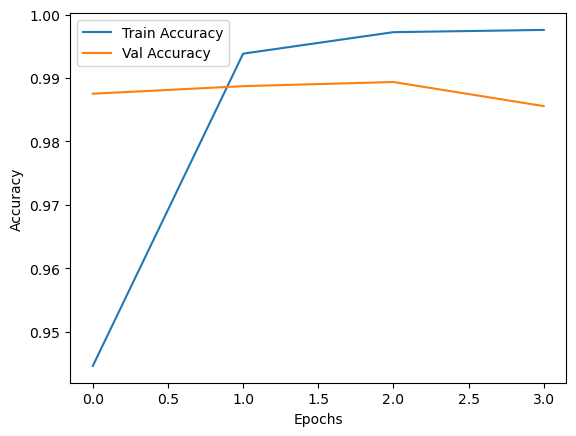

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 106s 74ms/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step

Training Metrics:
Accuracy: 0.9962265787647467
Precision: 0.9965314432212335
Recall: 0.9969072942596364
F1 Score: 0.9967193333081942

Testing Metrics:
Accuracy: 0.9883771359181195
Precision: 0.9888855512165815
Recall: 0.9909692956050572
F1 Score: 0.9899263268681401

Confusion Matrix (Test):
[[4811   74]
 [  60 6584]]


In [52]:
# training vs validation accuracy plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions on training and testing set
y_train_pred = (model.predict(X_train) > 0.5).astype(int)
y_test_pred  = (model.predict(X_test) > 0.5).astype(int)


# all Metrics
print("\nTraining Metrics:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))